In [1]:
from rdkit import Chem, Geometry
import tensorflow as tf
from model.G2C import G2C
import numpy as np
from av_utils import prepare_batch, sample_batch

C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Avish\miniconda3\envs\tsi

In [2]:
reactant_file = 'data/test_reactants.sdf'
product_file = 'data/test_products.sdf'

test_data = [Chem.ForwardSDMolSupplier(reactant_file, removeHs=False, sanitize=False),
             Chem.ForwardSDMolSupplier(product_file, removeHs=False, sanitize=False)]
# only keeps if not null
test_data = [(x,y) for (x,y) in zip(test_data[0], test_data[1]) if (x,y)] # len=842

elements = "HCNO"
num_elements = len(elements)
BATCH_SIZE = 1
MAX_SIZE = max([x.GetNumAtoms() for x,y in test_data]) # number of atoms in reactant with most atoms 
# this is same in test and train data

In [3]:
# make model
model = G2C(max_size=MAX_SIZE, node_features=num_elements+1, edge_features=3, layers=2, hidden_size=128, iterations=3)



Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.compat.v1.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to u

In [4]:
model_path = 'log/21Jul05_0938PM/' # e=10, l=2, h=128, i=3
# model_path = 'log/21May22_0910AM/' # e=10, l=2, h=128, i=3
# model_path = 'log/21Jul04_0536PM/' # e=10, l=2, h=128, i=3
# model_path = 'log/21Jul04_0520PM/' # e=10, l=2, h=128, i=3
# model_path = 'log/2layers_256hs_3its/best_model.ckpt' # saves model path here
final_model_path = model_path + 'best_model.ckpt' 

# Launch session
config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
with tf.Session(config=config) as sess:
    
    # Initialization
    print("Model loading...")
    saver = tf.train.Saver()
    saver.restore(sess, final_model_path) # restore best model
    print("Model restored")
    
    # Generator for test data
    get_test_data = sample_batch(test_data, BATCH_SIZE, MAX_SIZE)

    coords = np.empty([len(test_data), MAX_SIZE, 3])
    D_init = np.empty([len(test_data), MAX_SIZE, MAX_SIZE])
    W = np.empty([len(test_data), MAX_SIZE, MAX_SIZE])
    
    for step, data in enumerate(get_test_data):
        batch_dict_test, batch_mols_test = data
        feed_dict = {model.placeholders[key]: batch_dict_test[key] for key in batch_dict_test}
        coords[step*BATCH_SIZE:(step+1)*BATCH_SIZE, :, :] = sess.run([model.tensors["X"]], feed_dict=feed_dict)[0]
        D_init[step*BATCH_SIZE:(step+1)*BATCH_SIZE, :, :] = sess.run([model.tensors["D_init"]], feed_dict=feed_dict)[0]
        W[step*BATCH_SIZE:(step+1)*BATCH_SIZE, :, :] = sess.run([model.tensors["W"]], feed_dict=feed_dict)[0]

Model loading...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from log/21Jul05_0938PM/best_model.ckpt
Model restored


In [5]:
coords.shape, D_init.shape, W.shape

((842, 21, 3), (842, 21, 21), (842, 21, 21))

In [6]:
np.save(model_path + 'D_init.npy', D_init)
np.save(model_path + 'coords.npy', coords)
np.save(model_path + 'W.npy', W)
# need to save weights and embeddings if poss too

# Plot Distributions

In [7]:
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem

import numpy as np
from scipy import stats
from scipy.optimize import least_squares
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
### get test r,p,ts geometries and model ts geometries
### then load d_init - how did he get d_init.npy?
### tests all len 842, model_ts_no_opt is 840

base_folder = 'create_figs/model_data/'
test_ts_file = base_folder + 'test_ts.sdf'
reactant_file = base_folder + 'test_reactants.sdf'
product_file = base_folder + 'test_products.sdf'
model_ts_no_opt_file = base_folder + 'model_ts.sdf'

test_ts = Chem.ForwardSDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]

test_r = Chem.ForwardSDMolSupplier(reactant_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]

test_p = Chem.ForwardSDMolSupplier(product_file, removeHs=False, sanitize=False)
test_p = [x for x  in test_p]

model_ts_no_opt = Chem.ForwardSDMolSupplier(model_ts_no_opt_file, removeHs=False, sanitize=False)
model_ts_no_opt = [x for x  in model_ts_no_opt]

In [9]:
# don't need their final D. just D_init, GT, LA

# their model D_init
D_init = np.load(base_folder + 'D_init.npy')

# all the other D_init runs
d_inits = []
file_base_folder = 'data/saved-params/e10_l2_h128_i3_b20/'
# layers = 2, iterations = 3
D_init1 = np.load(file_base_folder + '1/D_init.npy') # e = 5, h = 128
d_inits.append(D_init1)
D_init2 = np.load(file_base_folder + '2/D_init.npy') # e = 5, h = 64
d_inits.append(D_init2)
D_init3 = np.load(file_base_folder + '3/D_init.npy') # e = 5, h = 32
d_inits.append(D_init3)
D_init4 = np.load(file_base_folder + '4/D_init.npy') # e = 10, h = 64
d_inits.append(D_init4)
D_init4 = np.load(file_base_folder + '5/D_init.npy') # e = 10, h = 64
d_inits.append(D_init4)
num_d_inits = len(d_inits)

In [10]:
# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(num_d_inits)]

for idx in range(len(test_ts)):

    # num_atoms + mask for reaction core
    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for i, d_init_list in enumerate(d_init_lists):
        d_init_lists[i].append(np.ravel(d_inits[i][idx][0:num_atoms, 0:num_atoms]*core_mask))
    
# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]
all_ds = [ds[ds != 0] for ds in all_ds]
ds_dict = {'gt': (all_ds[0], 'Ground Truth'), 'best_init': (all_ds[1], 'MIT D_init'),\
     'lin_approx': (all_ds[2], 'Linear Approximation')}
base_ds_counter = len(ds_dict)
for i in range(len(d_init_lists)):
    name = f'D_init{i+1}'
    ds_dict[name] = (all_ds[base_ds_counter + i], name)

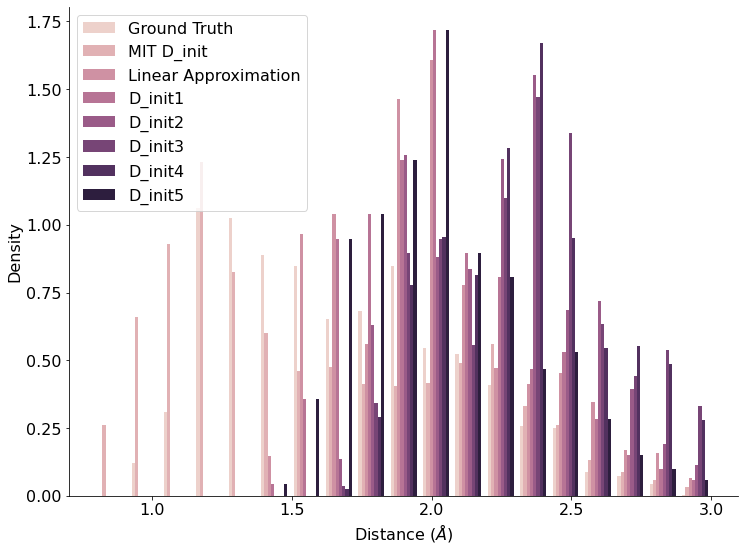

In [11]:
fig, ax = plt.subplots(figsize=(12,9))

ds_to_plot = [ds_dict[key][0] for key in ds_dict.keys()]
labels = [ds_dict[key][1] for key in ds_dict.keys()]
num_cols = len(ds_to_plot)

bins = np.linspace(0.8, 3, 20)
ax.hist(ds_to_plot, bins, range=(0.8, 3), density=True, label=labels, color=sns.cubehelix_palette(num_cols))
ax.legend(loc='upper right')

ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)   
#plt.savefig('dist_dists.png', bbox_inches='tight')

C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

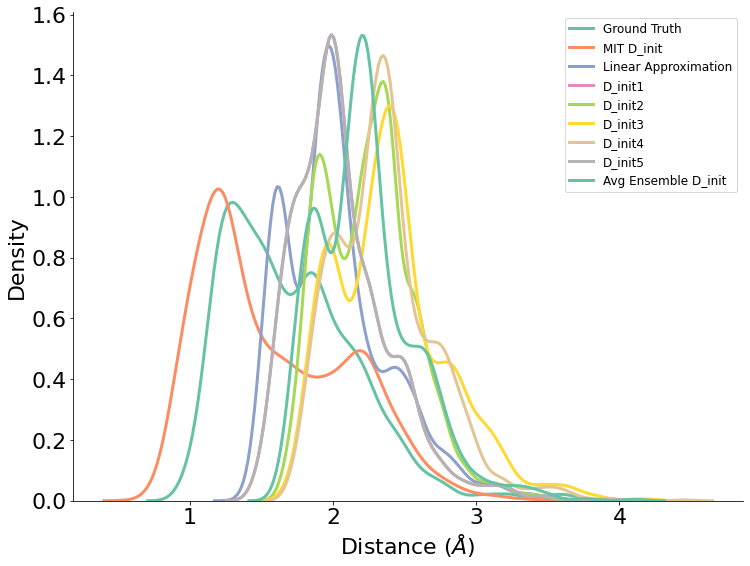

In [21]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
no_print = []

for i, key in enumerate(ds_dict.keys()):
    if key in no_print:
        continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

# Ensemble

Need to average out all the $D_{init}$ and then plots. Similar with $W$ and $X$.

In [16]:
# averaged ensemble of d_inits
ensemble_ds = []
d_inits
for i in range(len(ds_dict['best_init'][0])):
    ensemble_d = 0
    for j in range(1, num_d_inits + 1):
        ensemble_d += ds_dict[f'D_init{j}'][0][i]
    ensemble_d /= num_d_inits
    ensemble_ds.append(ensemble_d)

ds_dict['ens'] = (ensemble_ds, "Avg Ensemble D_init")

C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Avish\miniconda3\envs\tsir-rdkit-env1.1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

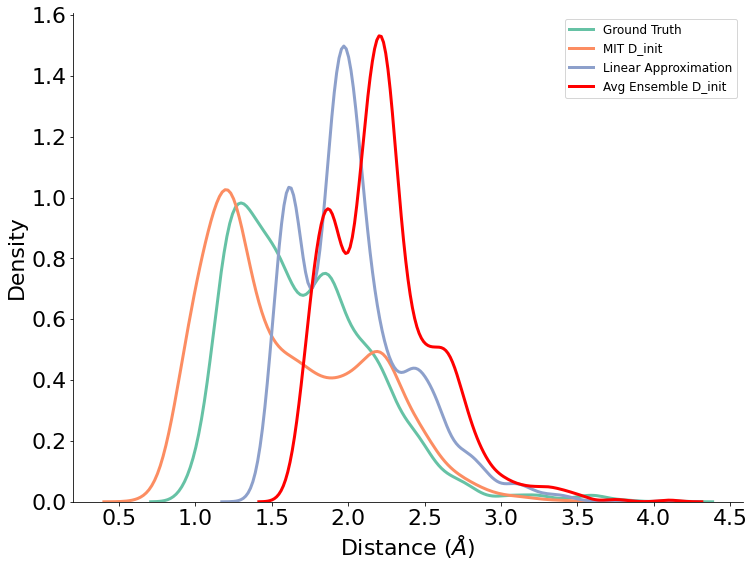

In [20]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
no_print = []
print_d_init = False
if not print_d_init:
    for j in range(1, num_d_inits + 1):
        no_print.append(f'D_init{j}')

for i, key in enumerate(ds_dict.keys()):
    if key in no_print:
        continue
    if key == 'ens':
        sns.distplot(ds_dict[key][0], color='red', kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)    
        continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 